In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import GPy
from IPython.display import display
import os
os.chdir("../..")
import descriptor.three_desc_model as tdm
from descriptor.cutoffs import Polynomial
GPy.plotting.change_plotting_library('matplotlib')

In [2]:
dataset = pd.read_csv('hornsrev_data.csv')#, index_col=0)

#dataset=dataset.drop(['ID','turb_num', 'wind_speed'], axis=1)

# dataset["IDnum"] = dataset["IDnum"] - dataset["IDnum"].iloc[0]
# numsims=(dataset["IDnum"].iloc[-1]-dataset["IDnum"].iloc[0])+1
symbol = "Siemens"
turb = [symbol]

In [3]:
# dataset['Sim_ID'] = dataset['Sim_ID'].str.replace('p00', '')
# dataset['Wind_Direction'] = dataset['Sim_ID'].apply(lambda x: x.split('_')[1]).astype(int)-270

In [4]:
# def rotate_coordinates(x, y, angle_degrees):
#     angle_radians = np.radians(angle_degrees)
#     x_rotated = x * np.cos(angle_radians) - y * np.sin(angle_radians)
#     y_rotated = x * np.sin(angle_radians) + y * np.cos(angle_radians)
#     return x_rotated, y_rotated

In [5]:
# # Rotate the coordinates based on Wind_Direction
# dataset['X_rotated'], dataset['Y_rotated'] = rotate_coordinates(dataset['X_coord'], dataset['Y_coord'], dataset['Wind_Direction'])

In [6]:
dataset

X_coord  Y_coord  Ref_Wind  Num_Turb          Sim_ID Turbine  \
0         0.0      0.0  6.112813        80  hornsrev_254_8      T1   
1        59.0   -558.0  6.112391        80  hornsrev_254_8      T2   
2       118.0  -1116.0  6.111544        80  hornsrev_254_8      T3   
3       177.0  -1674.0  6.103910        80  hornsrev_254_8      T4   
4       235.0  -2231.0  6.106692        80  hornsrev_254_8      T5   
...       ...      ...       ...       ...             ...     ...   
2635   5219.0  -1674.0  5.161035        80  hornsrev_286_8     T94   
2636   5278.0  -2231.0  5.151867        80  hornsrev_286_8     T95   
2637   5338.0  -2789.0  5.178098        80  hornsrev_286_8     T96   
2638   5397.0  -3347.0  5.149983        80  hornsrev_286_8     T97   
2639   5457.0  -3904.0  5.153124        80  hornsrev_286_8     T98   

      Wind_Direction    X_rotated    Y_rotated  
0                -16     0.000000     0.000000  
1                -16   -97.091204  -552.646630  
2                -16  -194.182409 -1105.293261  
3                -16  -291.273613 -1657.939891  
4                -16  -389.050442 -2209.349622  
...              ...          ...          ...  
2635              16  5478.241725  -170.600719  
2636              16  5688.486172  -689.760880  
2637              16  5899.967518 -1209.606665  
2638              16  6110.487603 -1729.728087  
2639              16  6321.693312 -2248.612610  

[2640 rows x 9 columns]

In [7]:
numsims=int(2640/80)

In [8]:
Gs = {"Siemens": [{"type":"G2", "turbine":"Siemens","eta":1.72065602, "offset": 1.12001978},
                  {"type":"G4", "elements":"Siemens","eta":2.54362242, "gamma":9.08207601},
                  {"type":"G6", "elements":"Siemens","eta":2.48427366, "gamma": 0.61244656}
                 ]}

In [9]:
nl=tdm.NeighborlistCalculator(cutoff=4001,cone_grad=0.12582561117875557, cone_offset=72.24947126849844)
Gs = {"Siemens": [{"type":"G2", "turbine":"Siemens","eta":4.25387599, "offset": 1.0151402},
                  {"type":"G4", "elements":"Siemens","eta":2.56450515, "gamma":8.04475192},
                  {"type":"G6", "elements":"Siemens","eta":2.33043463, "gamma": 0.50753377}
                 ]}
finpr=tdm.FingerprintCalculator(cutoff=4001,Gs=Gs,Rct=3000,delta_R=100,cone_grad=0.12582561117875557, cone_offset=72.24947126849844)
count=0
dataset_fp=np.empty(shape=(0, 3))
dataset_ws=np.empty(shape=(0, 1))
dataset_pos=np.empty(shape=(0, 2))
for i in range(numsims):
    numturb=dataset["Num_Turb"].iloc[count]
    position = np.empty((numturb,2))
    ws = np.empty((numturb,1))
    fp = np.empty((numturb,3))
    for k in range(numturb):
        position[k,0]=dataset.at[count,"X_rotated"]
        position[k,1]=dataset.at[count,"Y_rotated"]
        ws[k,0]=dataset.at[count,"Ref_Wind"]
        count = count+ 1
    neigh=nl.calculate(turb*numturb,position)
    fingerprints=finpr.calculate(turb*numturb,position,neigh,symbol)
    fingerprints=np.array(fingerprints)
    dataset_fp=np.append(dataset_fp,fingerprints,axis=0)
    dataset_ws=np.append(dataset_ws,ws,axis=0)
    dataset_pos=np.append(dataset_pos,position,axis=0)
dataset=np.concatenate((dataset_fp, dataset_ws),axis=1)
dataset = pd.DataFrame(dataset, columns = ['Fingerprint(G2)','Fingerprint(G4)','Fingerprint(G6)','Ref_Wind_Speed'])
X=dataset[["Fingerprint(G2)","Fingerprint(G4)","Fingerprint(G6)"]].to_numpy()
Y=dataset[["Ref_Wind_Speed"]].to_numpy()
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)
Xtrain=train_dataset[["Fingerprint(G2)","Fingerprint(G4)","Fingerprint(G6)"]].to_numpy()
Ytrain=train_dataset[["Ref_Wind_Speed"]].to_numpy()
Xtest=test_dataset[["Fingerprint(G2)","Fingerprint(G4)","Fingerprint(G6)"]].to_numpy()
Ytest=test_dataset[["Ref_Wind_Speed"]].to_numpy()

In [10]:
# define kernel
ker = GPy.kern.RBF(3,lengthscale=0.1)# + GPy.kern.White(2)

In [11]:
# create simple GP model
m = GPy.models.GPRegression(Xtrain,Ytrain,ker)

In [12]:
# optimize and plot
m.optimize(messages=True,max_f_eval = 1000)
#fig = m.plot()
#display(GPy.plotting.show(fig, filename='basic_gp_regression_notebook_2d'))
display(m)

In [13]:
print(m)


Name : GP regression
Objective : -2092.6557686543247
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                 value  |  constraints  |  priors
  rbf.variance             |    12.074866771015659  |      +ve      |        
  rbf.lengthscale          |   0.07664578217766602  |      +ve      |        
  Gaussian_noise.variance  |  0.004873769270054354  |      +ve      |        


In [14]:
[Ypred,Yvar]=m.predict(Xtest)
error_test=np.abs(Ypred-Ytest)
np.mean(error_test)

0.0434881086144718

In [15]:
[Yval,Yvalvar]=m.predict(Xtrain)
error_train=np.abs(Yval-Ytrain)
np.mean(error_train)

0.0408031432606046

In [16]:
[Yall,Yallvar]=m.predict(X)
error_all=np.abs(Yall-Y)
np.mean(error_all)

0.04134013633137804

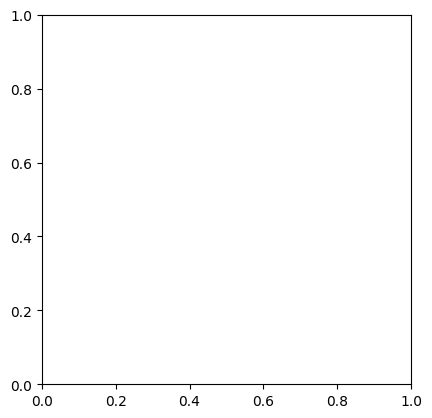

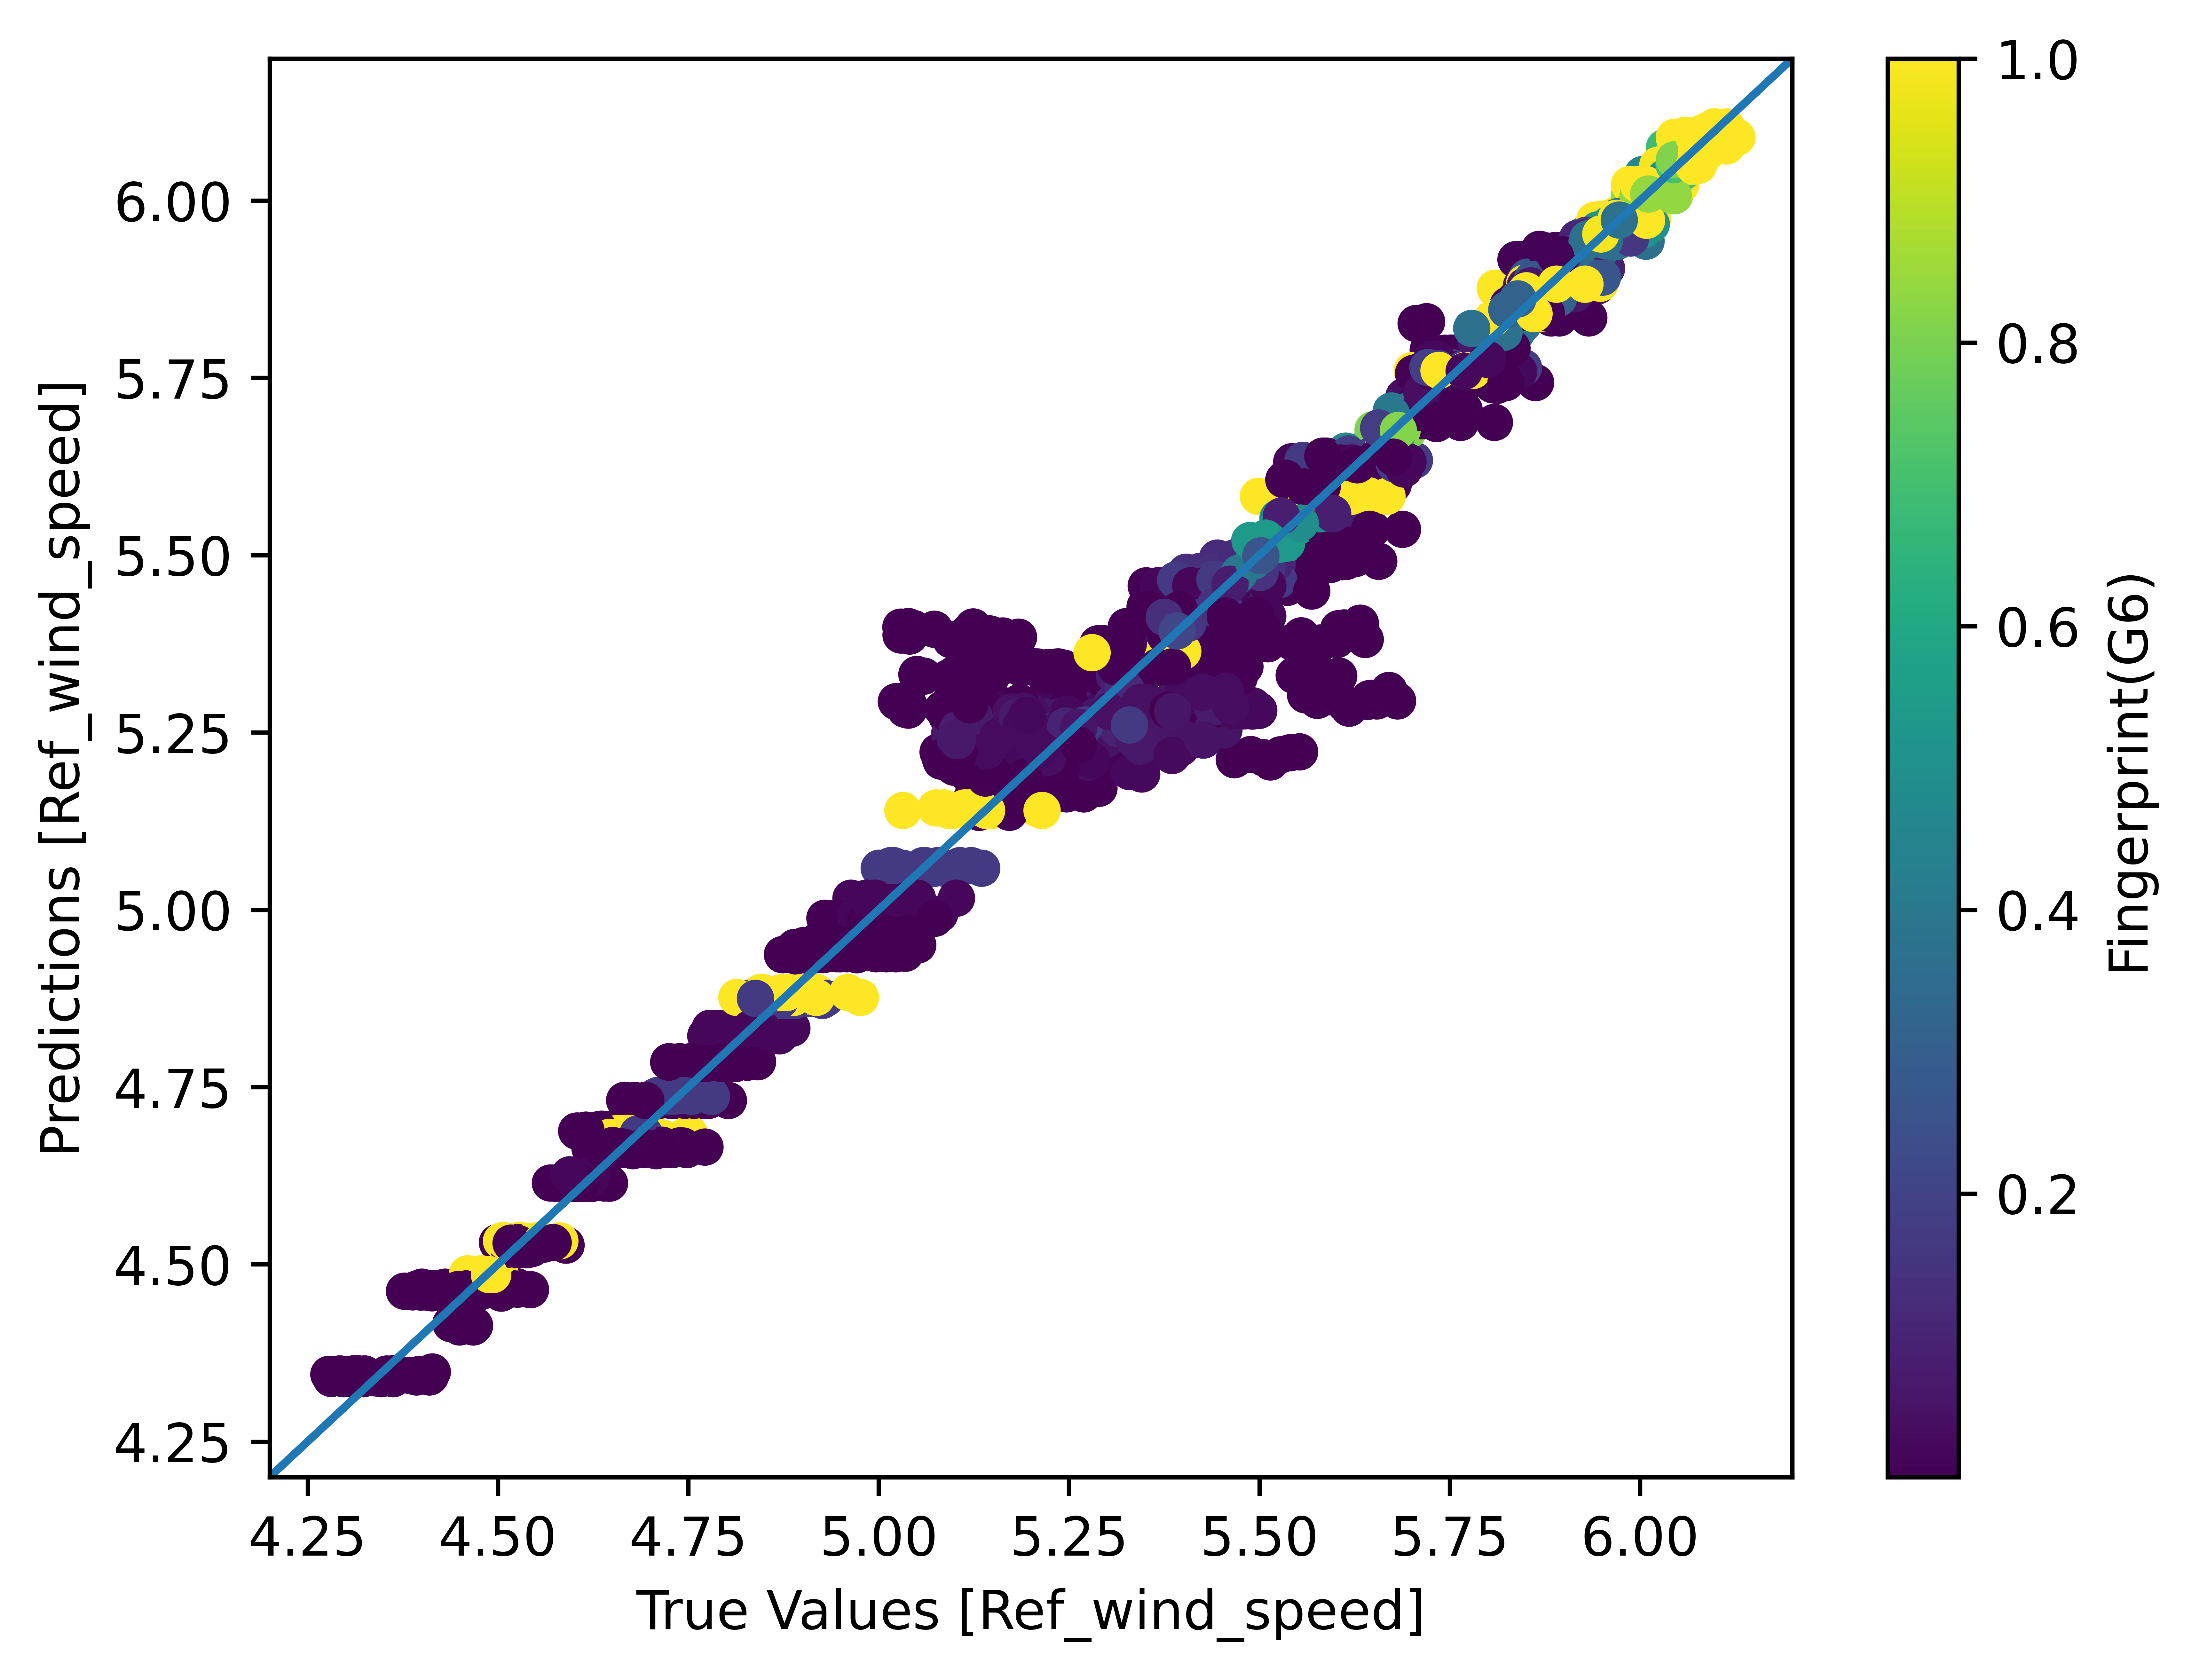

In [33]:
a = plt.axes(aspect='equal')
plt.figure(dpi=1200)
plt.scatter(Ytest, Ypred,c=Xtest[:,2])     #"Fingerprint(G2)"
plt.scatter(Ytrain, Yval,c=Xtrain[:,2])  #"Fingerprint(G2)"
plt.xlabel('True Values [Ref_wind_speed]')
plt.ylabel('Predictions [Ref_wind_speed]')
cbar=plt.colorbar()
cbar.set_label('Fingerprint(G6)')
lims = [4.2, 6.2]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

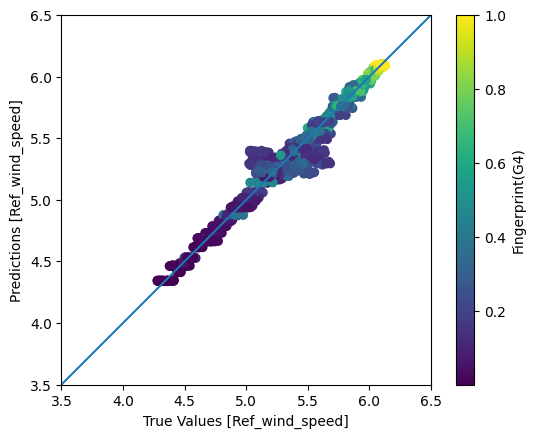

In [18]:
a = plt.axes(aspect='equal')
plt.scatter(Ytest, Ypred,c=Xtest[:,1])     #"Fingerprint(G4)"
plt.scatter(Ytrain, Yval,c=Xtrain[:,1])  #"Fingerprint(G4)"
plt.xlabel('True Values [Ref_wind_speed]')
plt.ylabel('Predictions [Ref_wind_speed]')
cbar=plt.colorbar()
cbar.set_label('Fingerprint(G4)')
lims = [3.5, 6.5]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

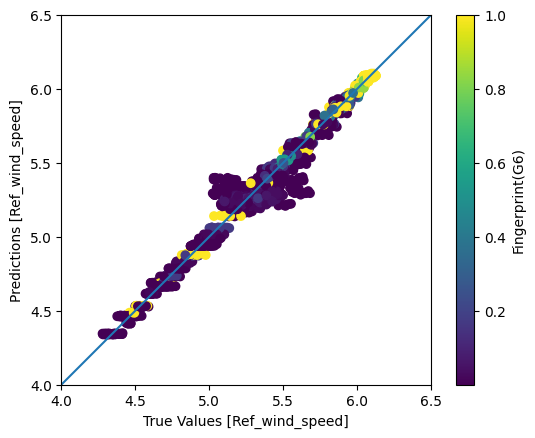

In [19]:
a = plt.axes(aspect='equal')
plt.scatter(Ytest, Ypred,c=Xtest[:,2])     #"Fingerprint(G6)"
plt.scatter(Ytrain, Yval,c=Xtrain[:,2])  #"Fingerprint(G6)"
plt.xlabel('True Values [Ref_wind_speed]')
plt.ylabel('Predictions [Ref_wind_speed]')
cbar=plt.colorbar()
cbar.set_label('Fingerprint(G6)')
lims = [4, 6.5]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

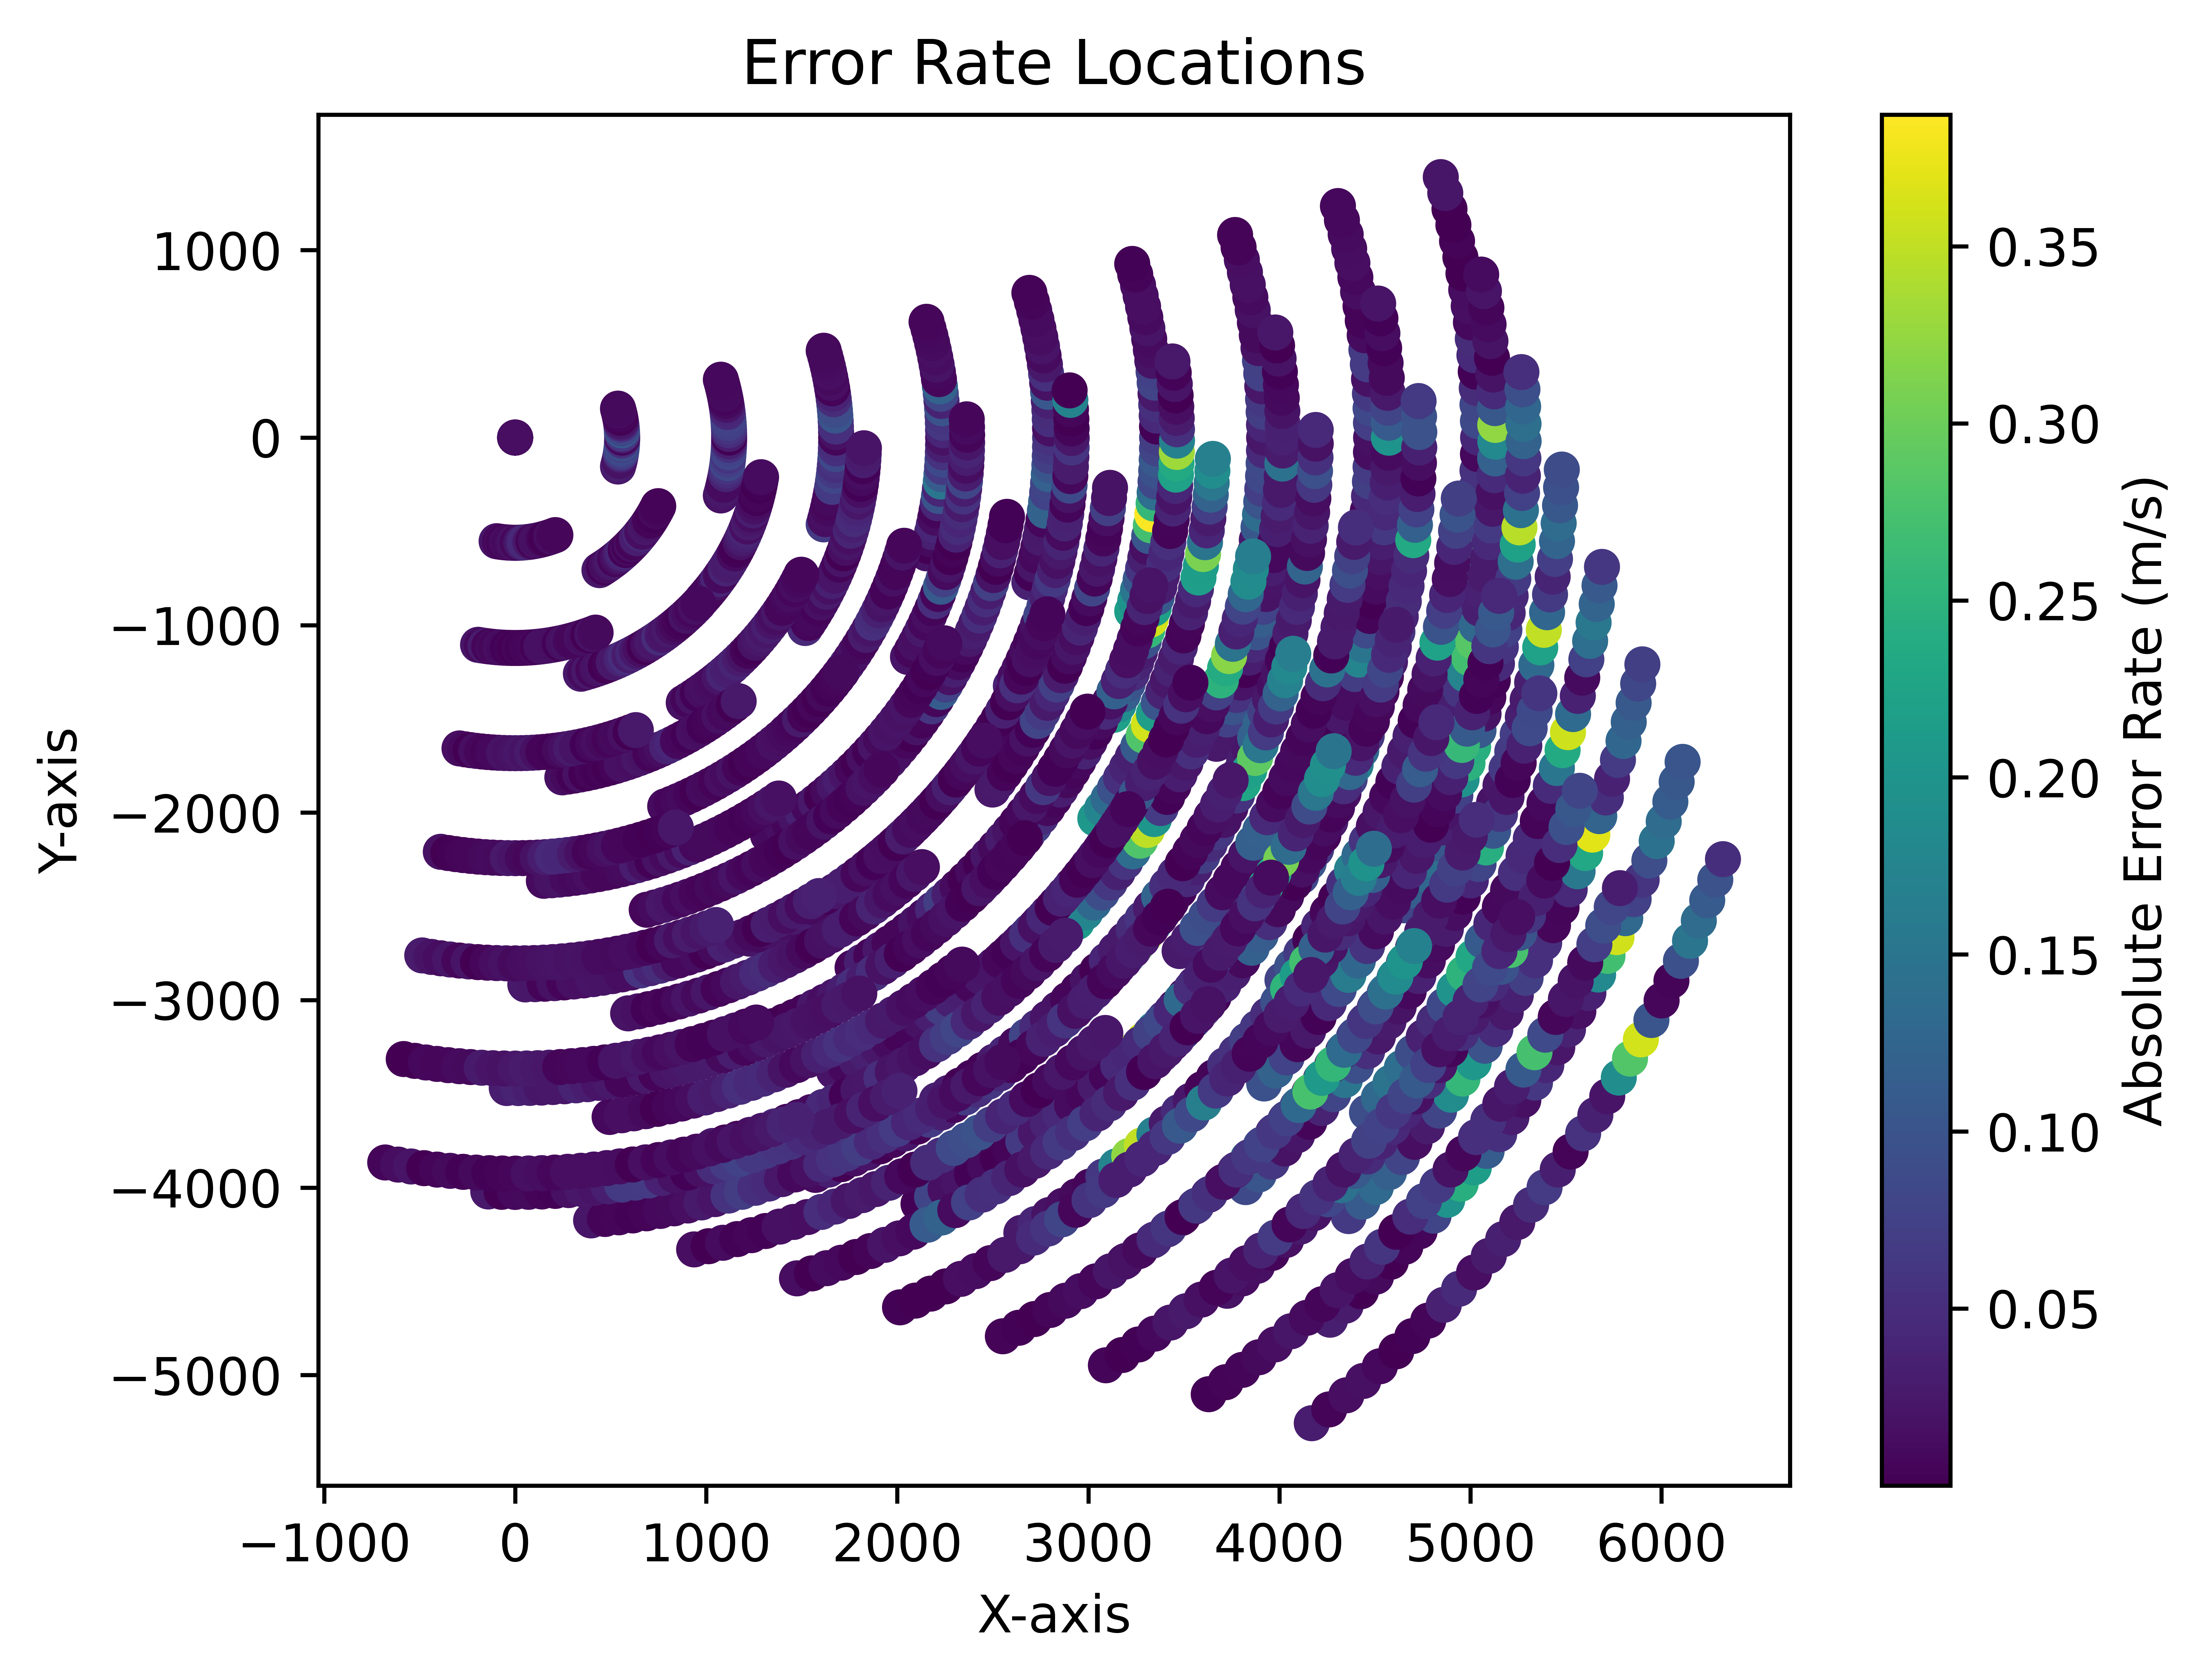

In [20]:
plt.figure(dpi=1200)
plt.scatter(dataset_pos[:,0], dataset_pos[:,1],c=error_all)
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Error Rate Locations')
cbar=plt.colorbar()
cbar.set_label('Absolute Error Rate (m/s)')

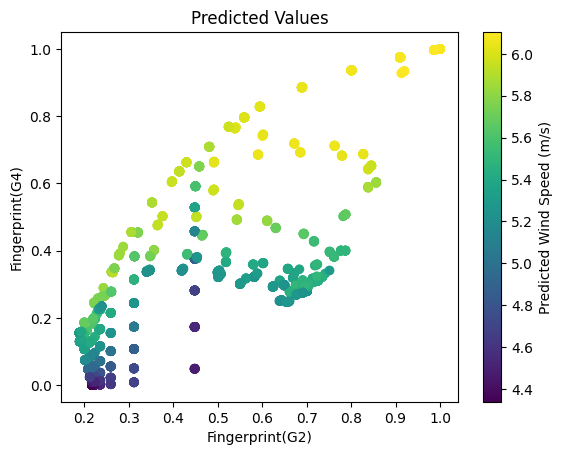

In [31]:
a = plt.axes
plt.scatter(Xtest[:,0], Xtest[:,1],c=np.abs(Ypred))
plt.scatter(Xtrain[:,0], Xtrain[:,1],c=np.abs(Yval))
#plt.scatter(train_labels, train_predictions)
plt.xlabel('Fingerprint(G2)')
plt.ylabel('Fingerprint(G4)')
plt.title('Predicted Values')
cbar=plt.colorbar()
cbar.set_label('Predicted Wind Speed (m/s)')

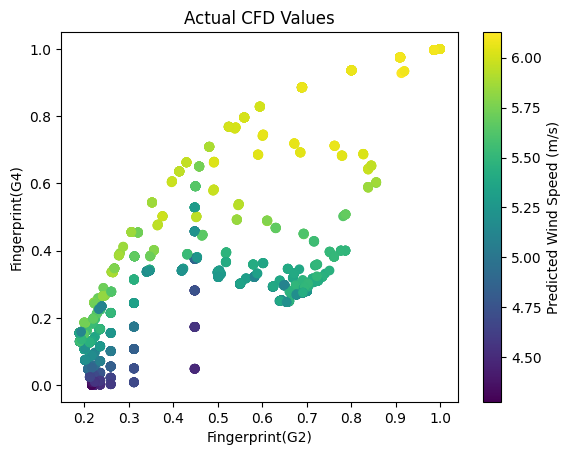

In [30]:
a = plt.axes
plt.scatter(Xtest[:,0], Xtest[:,1],c=np.abs(Ytest))
plt.scatter(Xtrain[:,0], Xtrain[:,1],c=np.abs(Ytrain))
#plt.scatter(train_labels, train_predictions)
plt.xlabel('Fingerprint(G2)')
plt.ylabel('Fingerprint(G4)')
plt.title('Actual CFD Values')
cbar=plt.colorbar()
cbar.set_label('Predicted Wind Speed (m/s)')

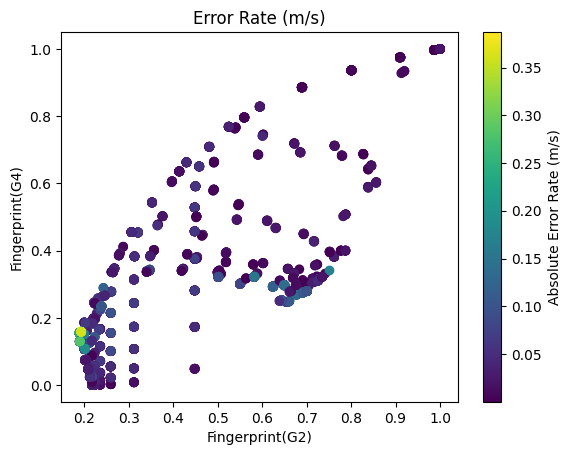

In [23]:
a = plt.axes
plt.scatter(X[:,0], X[:,1],c=error_all)
#plt.scatter(Xtrain[:,0], Xtrain[:,1],c=np.abs(Ytrain))
#plt.scatter(train_labels, train_predictions)
plt.xlabel('Fingerprint(G2)')
plt.ylabel('Fingerprint(G4)')
plt.title('Error Rate (m/s)')
cbar=plt.colorbar()
cbar.set_label('Absolute Error Rate (m/s)')

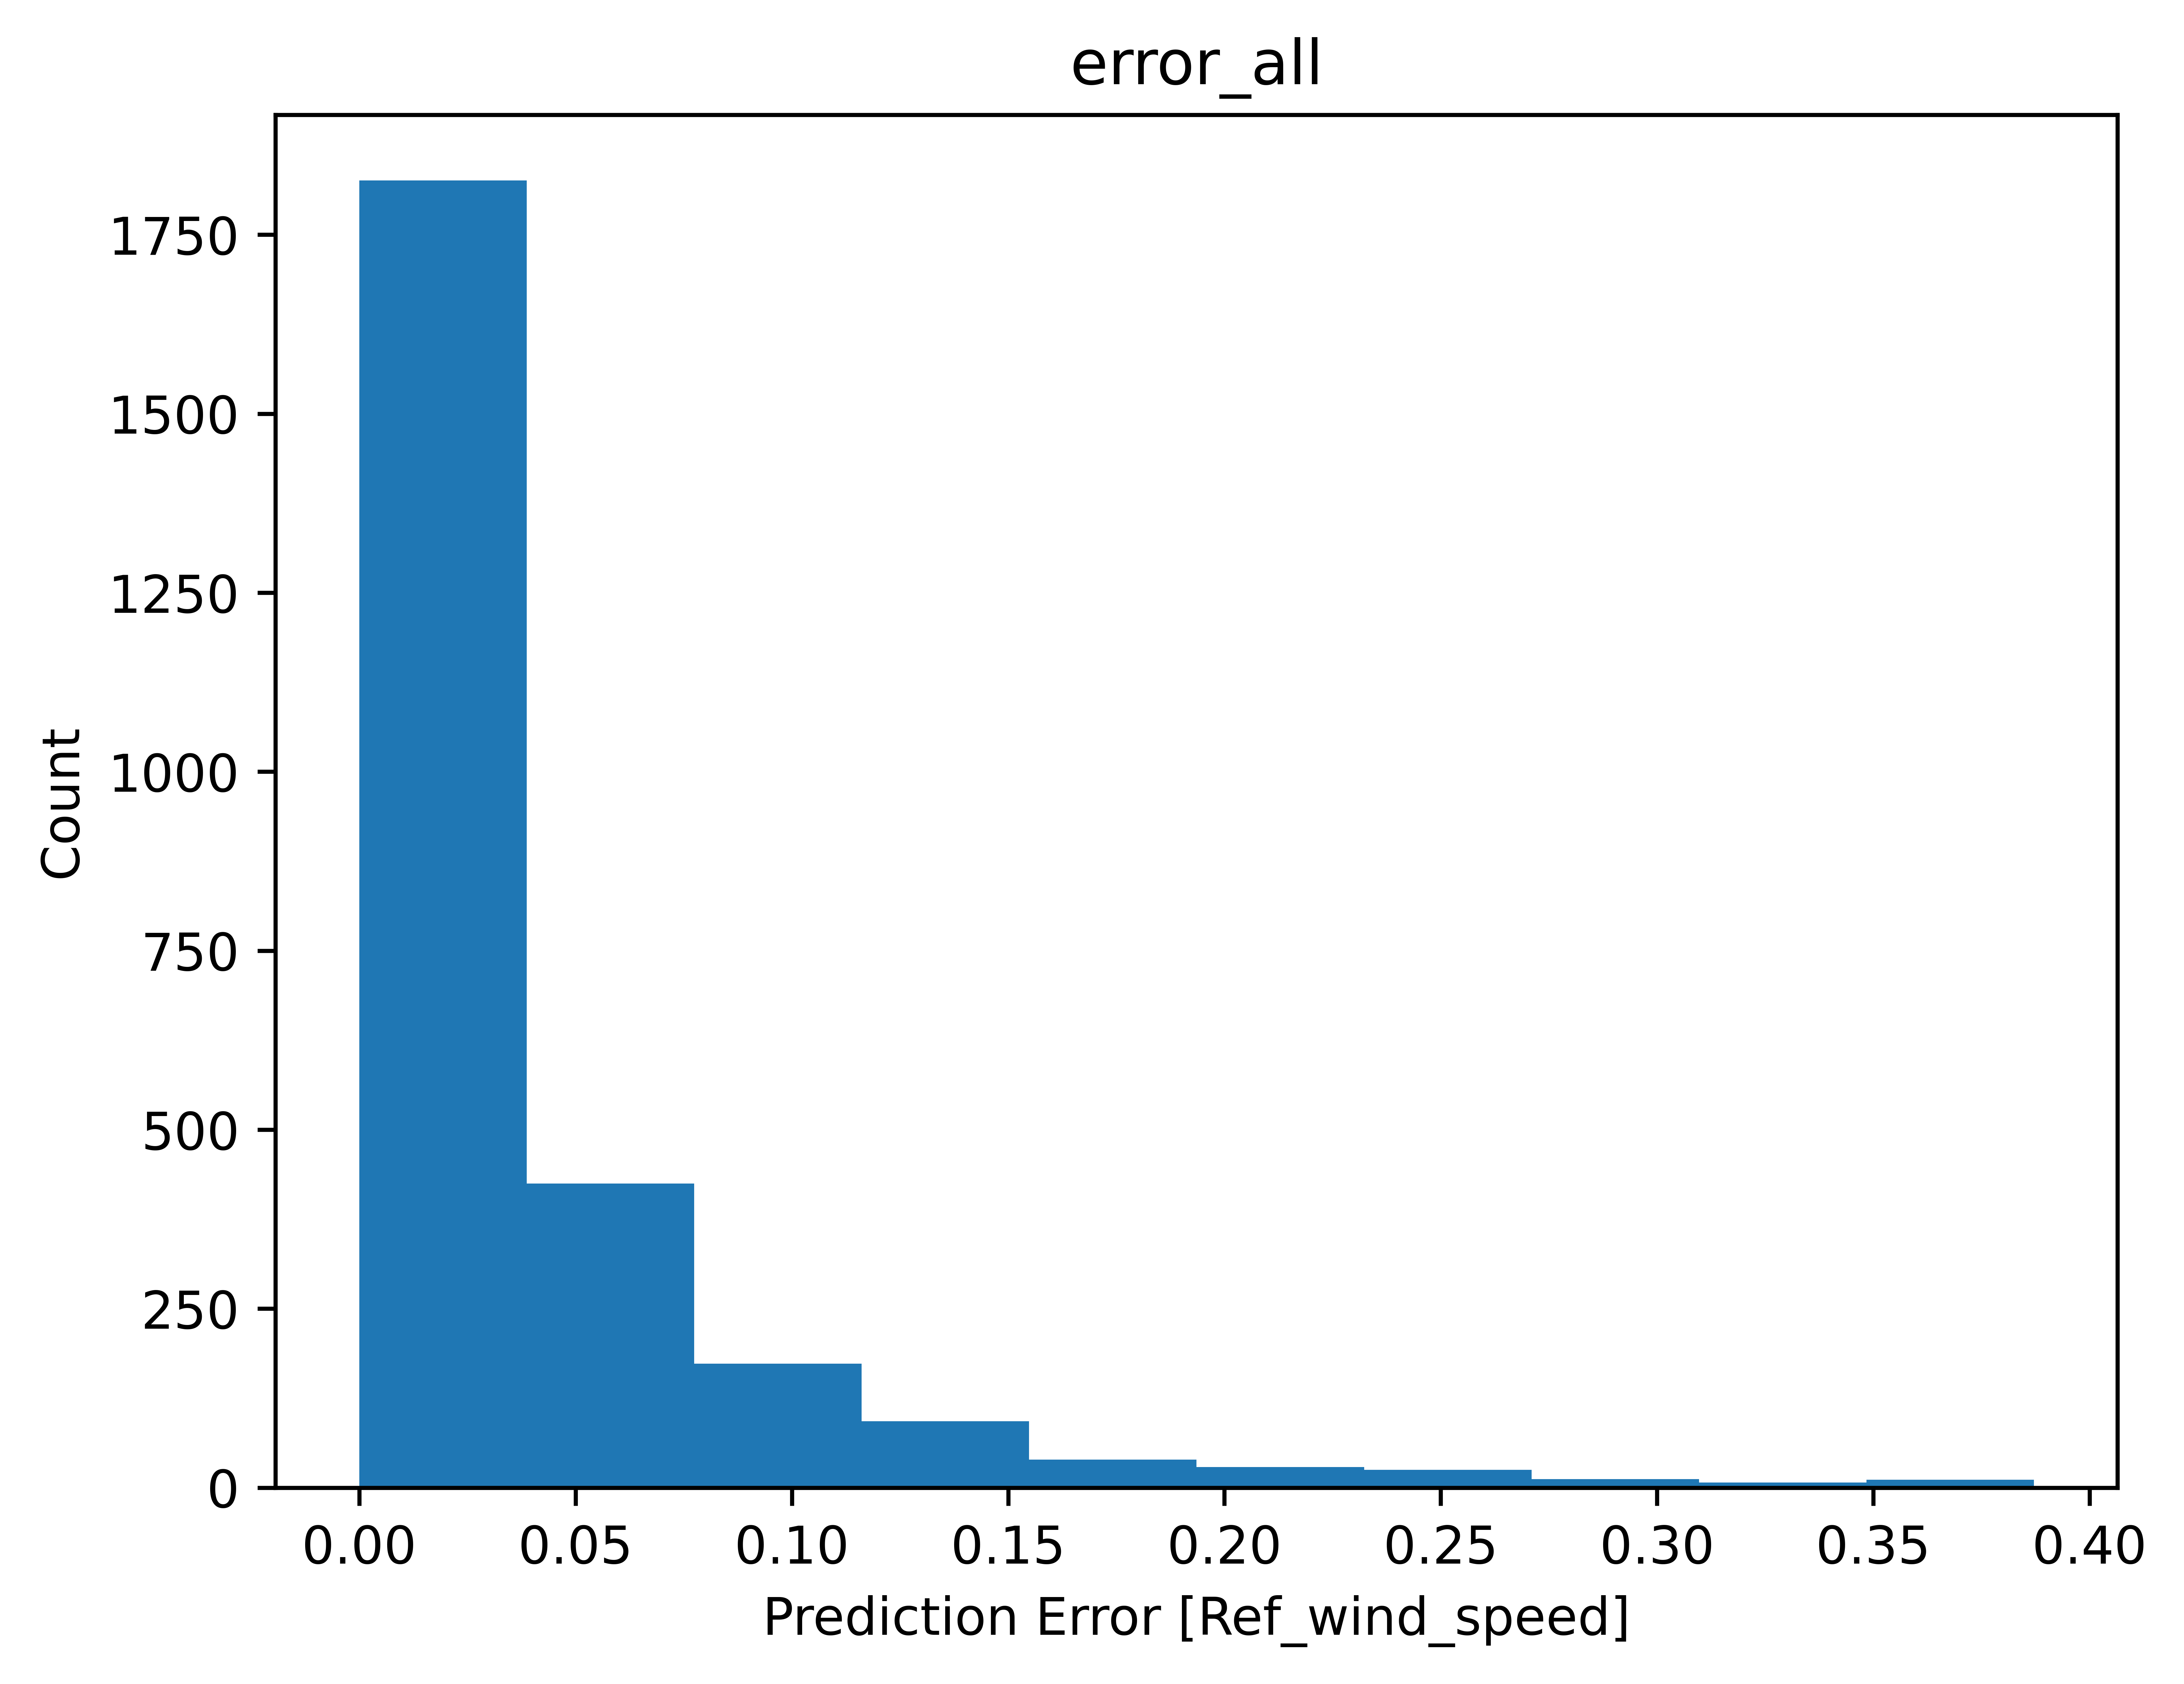

In [34]:
plt.figure(dpi=1200)
plt.hist(error_all, bins=10)
plt.xlabel('Prediction Error [Ref_wind_speed]')
plt.title('error_all')
_ = plt.ylabel('Count')

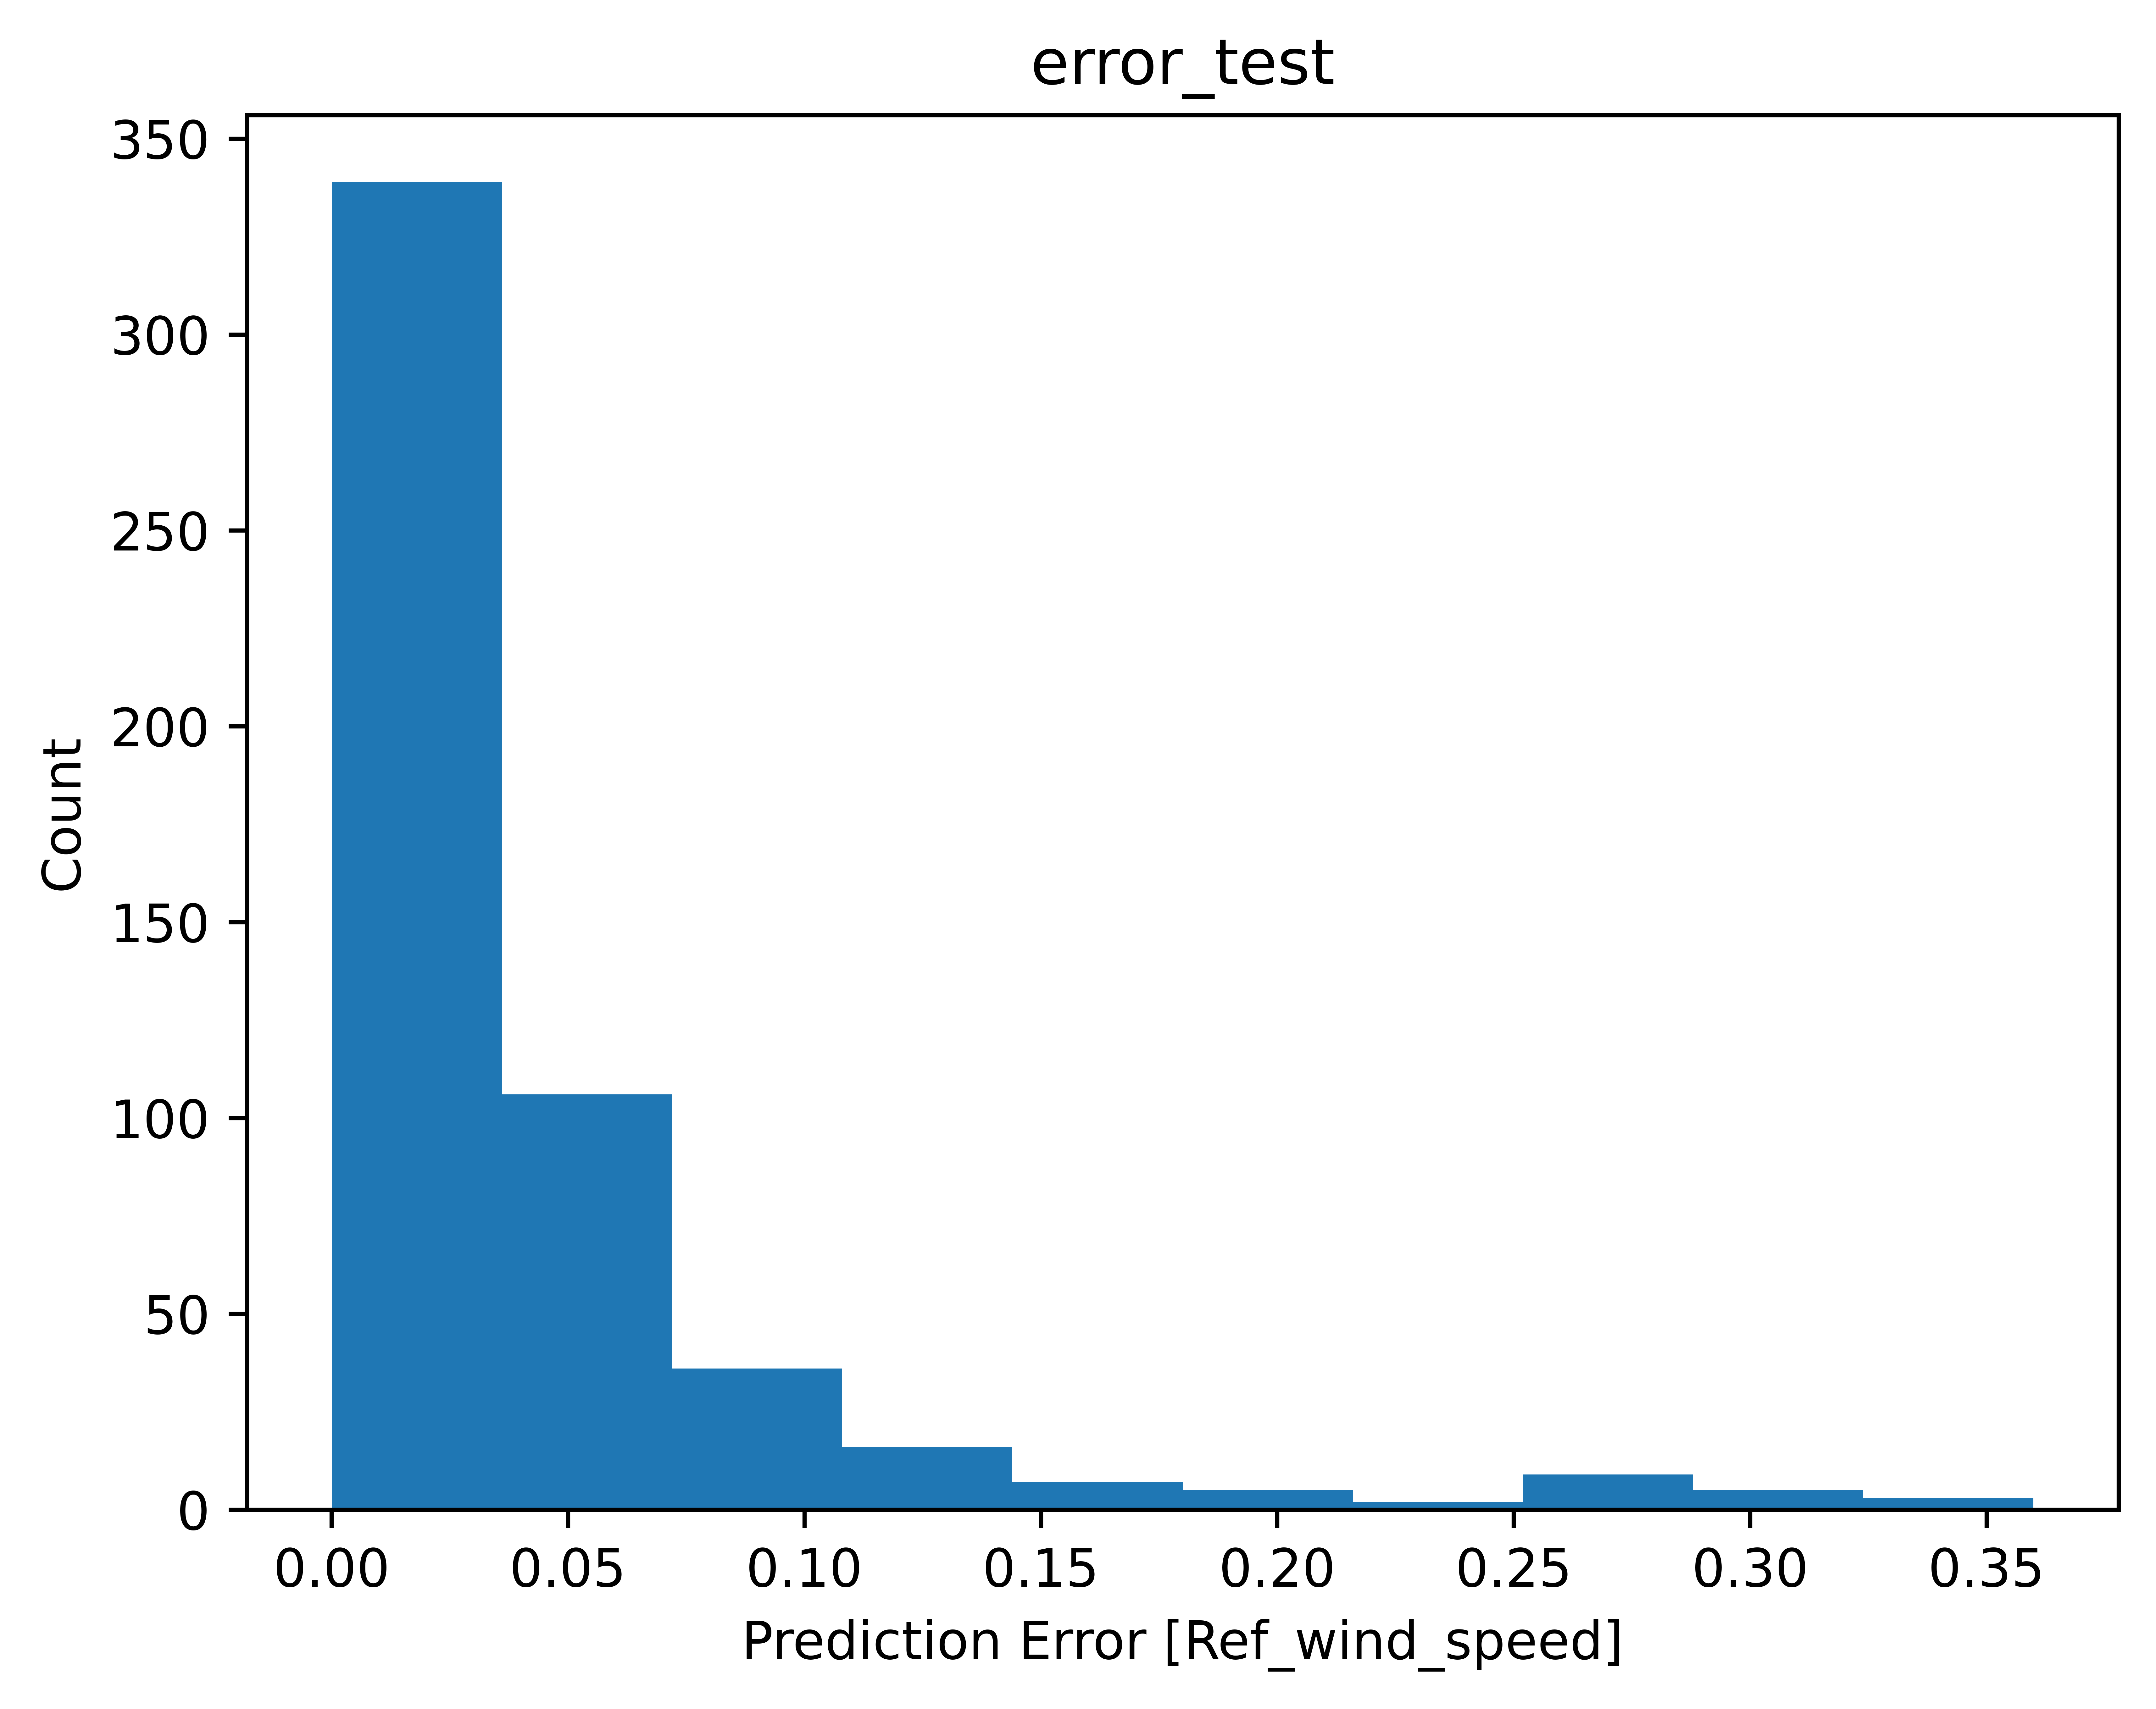

In [25]:
plt.figure(dpi=1200)
plt.hist(error_test, bins=10)
plt.xlabel('Prediction Error [Ref_wind_speed]')
plt.title('error_test')
_ = plt.ylabel('Count')